In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, Aer, IBMQ, transpile, assemble, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
# Local modules

In [2]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

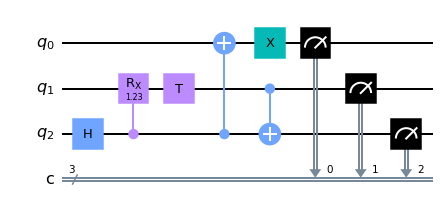

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[2])
circuit.crx(0.391826552*pi, qreg_q[2], qreg_q[1])
circuit.t(qreg_q[1])
circuit.cx(qreg_q[2], qreg_q[0])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.x(qreg_q[0])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])

#editor = CircuitComposer(circuit=circuit)
#editor
circuit.draw()

In [5]:
for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = 'simulated'
    print(f'{backend.name()} has {backend.status().pending_jobs} queud and {qubit_count} qubits')

ibmq_qasm_simulator has 1 queud and simulated qubits
ibmqx2 has 681 queud and 5 qubits
ibmq_16_melbourne has 4 queud and 15 qubits
ibmq_armonk has 2 queud and 1 qubits
ibmq_athens has 19 queud and 5 qubits
ibmq_santiago has 18 queud and 5 qubits
ibmq_lima has 31 queud and 5 qubits
ibmq_belem has 96 queud and 5 qubits
ibmq_quito has 13 queud and 5 qubits
simulator_statevector has 2 queud and simulated qubits
simulator_mps has 3 queud and simulated qubits
simulator_extended_stabilizer has 3 queud and simulated qubits
simulator_stabilizer has 2 queud and simulated qubits


In [5]:
backend = provider.get_backend('ibmq_santiago')

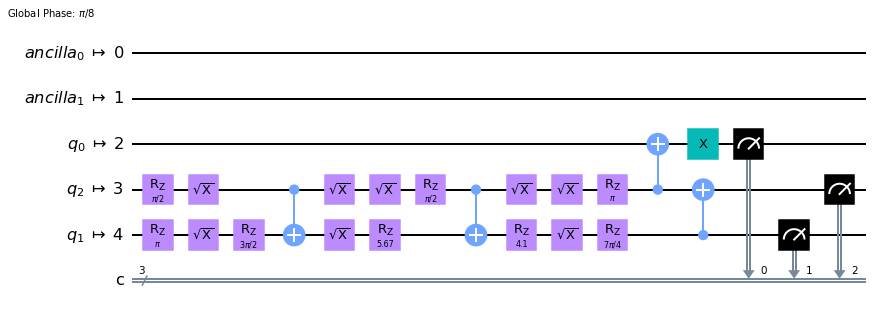

In [11]:
t_circuit = transpile(circuit, backend, initial_layout=[2, 4, 3], optimization_level=3)
#plot_circuit_layout(t_circuit, backend)
qobj1 = assemble(t_circuit, backend=backend, shots=8192)
t_circuit.draw()

In [10]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
t_qc = transpile(meas_calibs, backend=backend, initial_layout=[2, 4, 3])
qobj2 = assemble(t_qc, backend=backend, shots=8192)

In [188]:
results = backend.run(qobj1).result()
cal_results = backend.run(qobj2).result()

In [189]:
noisy_counts = results.get_counts()
print(noisy_counts)

{'000': 144, '001': 3940, '010': 1315, '011': 28, '100': 2593, '101': 64, '110': 19, '111': 89}


In [190]:
# Get the filter object
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

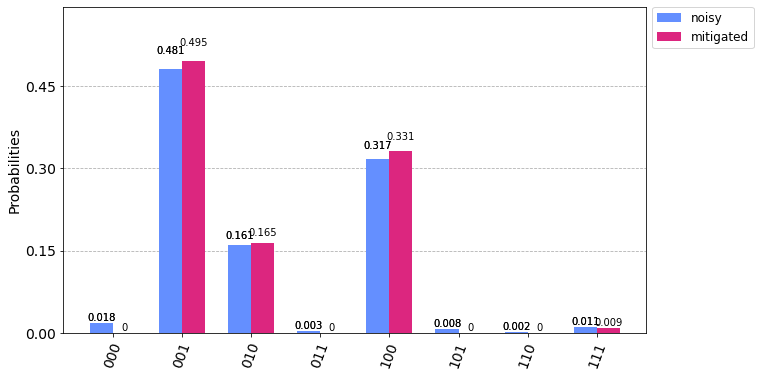

In [192]:
fig = plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])
fig.subplots_adjust(right=0.8)
fig.set_size_inches(12, 6)
fig.savefig('kstate_hist.png', dpi=100)
fig

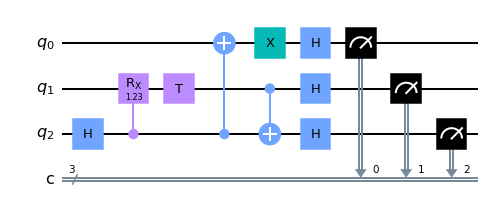

In [5]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuith = QuantumCircuit(qreg_q, creg_c)

circuith.h(qreg_q[2])
circuith.crx(0.391826552*pi, qreg_q[2], qreg_q[1])
circuith.t(qreg_q[1])
circuith.cx(qreg_q[2], qreg_q[0])
circuith.cx(qreg_q[1], qreg_q[2])
circuith.x(qreg_q[0])
circuith.h(qreg_q[0])
circuith.h(qreg_q[1])
circuith.h(qreg_q[2])
circuith.measure(qreg_q[0], creg_c[0])
circuith.measure(qreg_q[1], creg_c[1])
circuith.measure(qreg_q[2], creg_c[2])

#editor = CircuitComposer(circuit=circuit)
#editor
circuith.draw()

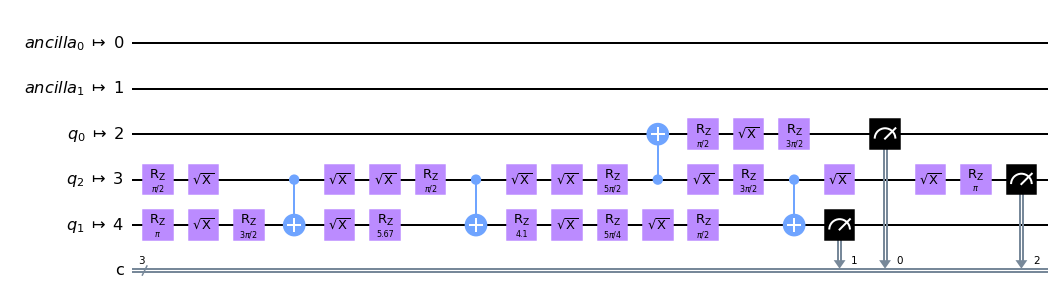

In [13]:
t_circuith = transpile(circuith, backend, initial_layout=[2, 4, 3], optimization_level=3)
#plot_circuit_layout(t_circuith, backend)
qobj1h = assemble(t_circuith, backend=backend, shots=8192)
t_circuith.draw()

In [14]:
resultsh = backend.run(qobj1h).result()
cal_resultsh = backend.run(qobj2).result()
noisy_countsh = resultsh.get_counts()
print(noisy_countsh)
# Get the filter object
meas_fitterh = CompleteMeasFitter(cal_resultsh, state_labels, circlabel='mcal')
meas_filterh = meas_fitterh.filter
# Results with mitigation
mitigated_resultsh = meas_filterh.apply(resultsh)
mitigated_countsh = mitigated_resultsh.get_counts()

{'000': 2625, '001': 188, '010': 1036, '011': 332, '100': 337, '101': 1123, '110': 197, '111': 2354}


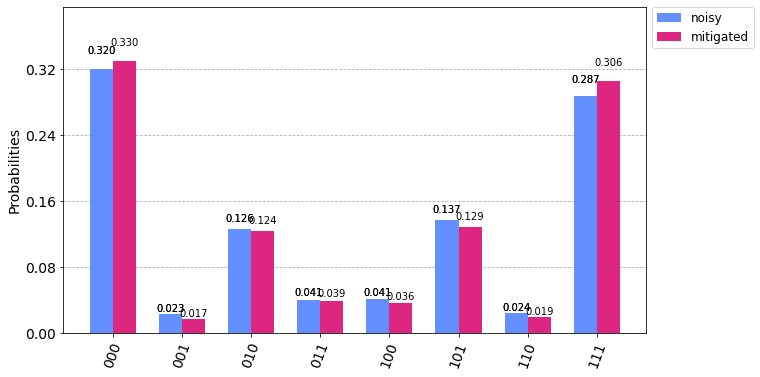

In [15]:
figh = plot_histogram([noisy_countsh, mitigated_countsh], legend=['noisy', 'mitigated'])
figh.subplots_adjust(right=0.8)
figh.set_size_inches(12, 6)
figh.savefig('kstateh_hist.png', dpi=100)
figh